# Training Mars Landmark Identifier Model with Convolutional Neural Network

### Python 2/3 Compatibility Import

In [1]:
### Python 2/3 Compatibility Import
from __future__ import absolute_import, division, print_function, unicode_literals

### Imports

In [26]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os # for parallelization

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Pre-processing Functions

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [4]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [5]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#### Declarations

In [6]:
# Mars Landmark Classes
CLASS_NAMES = np.array([
    "other",
    "crater",
    "dark dune",
    "slope streak",
    "bright dune",
    "impact ejecta",
    "swiss cheese",
    "spider",
])

# Image Size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

#### Loading

In [69]:
def filter_sample(ds, category):
    filtered_ds = ds.unbatch()
    filtered_ds = filtered_ds.filter(lambda features, label: label.numpy() == category).repeat()
    return filtered_ds

In [46]:
train_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/training/*/*"))
train_ds = train_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
test_files = tf.data.Dataset.list_files(str("hirise-map-proj-v3/testing/*/*"))
test_ds = test_files.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [70]:
other_ds = filter_sample(train_ds, [True,False,False,False,False,False,False,False])

ValueError: Cannot unbatch an input whose components have different batch sizes.

In [9]:
# Check Data
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Image: ", image.numpy())
    print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Image:  [[[0.4875482  0.4875482  0.4875482 ]
  [0.46212795 0.46212795 0.46212795]
  [0.42060784 0.42060784 0.42060784]
  ...
  [0.43104663 0.43104663 0.43104663]
  [0.42115524 0.42115524 0.42115524]
  [0.3970326  0.3970326  0.3970326 ]]

 [[0.5015581  0.5015581  0.5015581 ]
  [0.47299993 0.47299993 0.47299993]
  [0.46105158 0.46105158 0.46105158]
  ...
  [0.40432158 0.40432158 0.40432158]
  [0.45219317 0.45219317 0.45219317]
  [0.44734344 0.44734344 0.44734344]]

 [[0.5104493  0.5104493  0.5104493 ]
  [0.5093665  0.5093665  0.5093665 ]
  [0.47551692 0.47551692 0.47551692]
  ...
  [0.39772543 0.39772543 0.39772543]
  [0.41808194 0.41808194 0.41808194]
  [0.43680415 0.43680415 0.43680415]]

 ...

 [[0.4018712  0.4018712  0.4018712 ]
  [0.35597852 0.35597852 0.35597852]
  [0.34539306 0.34539306 0.34539306]
  ...
  [0.28209254 0.28209254 0.28209254]
  [0.29973277 0.29973277 0.29973277]
  [0.29803923 0.29803923 0.29803923]]

 [[0.41913962 0.41913962 0.41913962]
 

#### Batching

In [33]:
# Basic Class_Func
def class_func(features, label):
    return label

In [35]:
# Balanced Proportion
proportion = [(BATCH_SIZE/len(CLASS_NAMES))/BATCH_SIZE] * len(CLASS_NAMES)

# Resampler to balance batches
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=proportion)

In [44]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)
    ds_resample = ds.unbatch().apply(resampler).batch(BATCH_SIZE)
    ds_balanced = ds_resample.map(lambda extra_label, features_and_label: features_and_label)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds_balanced

In [39]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [47]:
X_train = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(X_train))

TypeError: in converted code:

    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/data/experimental/ops/resampling.py:176 update_estimate_and_tile
        c, num_examples_per_class_seen)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/data/experimental/ops/resampling.py:212 _estimate_data_distribution
        array_ops.one_hot(c, num_classes, dtype=dtypes.int64), 0))
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:3645 one_hot
        name)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py:5556 one_hot
        off_value=off_value, axis=axis, name=name)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:576 _apply_op_helper
        param_name=input_name)
    /Users/knytes/anaconda3/envs/machinelearning/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py:61 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'indices' has DataType bool not in list of allowed values: uint8, int32, int64


In [32]:
for f in X_train.take(1):
    print(f)

(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[0.41152185, 0.41152185, 0.41152185],
         [0.38532037, 0.38532037, 0.38532037],
         [0.39226413, 0.39226413, 0.39226413],
         ...,
         [0.5106465 , 0.5106465 , 0.5106465 ],
         [0.47625172, 0.47625172, 0.47625172],
         [0.5138612 , 0.5138612 , 0.5138612 ]],

        [[0.38402918, 0.38402918, 0.38402918],
         [0.37591505, 0.37591505, 0.37591505],
         [0.37570727, 0.37570727, 0.37570727],
         ...,
         [0.5089572 , 0.5089572 , 0.5089572 ],
         [0.4673673 , 0.4673673 , 0.4673673 ],
         [0.51232713, 0.51232713, 0.51232713]],

        [[0.43711084, 0.43711084, 0.43711084],
         [0.41377407, 0.41377407, 0.41377407],
         [0.3806353 , 0.3806353 , 0.3806353 ],
         ...,
         [0.50112766, 0.50112766, 0.50112766],
         [0.480856  , 0.480856  , 0.480856  ],
         [0.5278845 , 0.5278845 , 0.5278845 ]],

        ...,

        [[0.37822968, 0.37822968

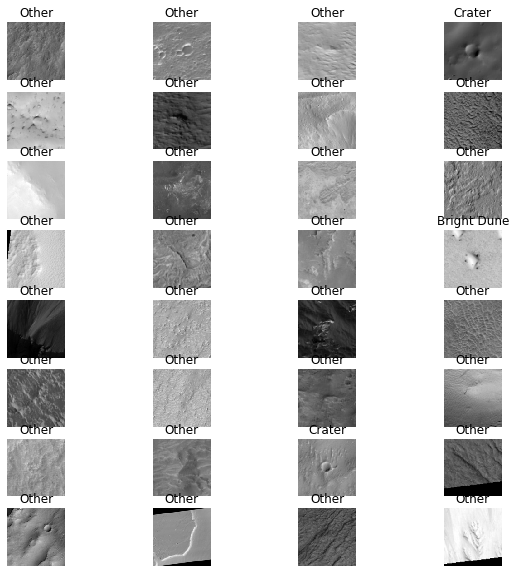

In [13]:
# Preview batch
show_batch(image_batch.numpy(), label_batch.numpy())

### Modeling

In [16]:
# Load Model
prev_model = tf.keras.models.load_model('models/20200220-151319.h5')
prev_model.summary()

Model: "MLI_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211

In [ ]:
# CNN Model
model = Sequential(name="MLI_CNN")
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

### Compile & Train

In [19]:
# Compile model
prev_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Logs for Tensorboard
if os.name == "nt":
    log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
else:
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
# Fitting
MLI_FIT = prev_model.fit(X_train,
                    epochs=10,
                    steps_per_epoch=100,
                    callbacks=[tensorboard_callback],
                    validation_data=prepare_for_training(test_ds),
                    validation_steps=50
                    )
# Save Model
if os.name == "nt":
    prev_model.save("models\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")
else:
    prev_model.save("models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 35s 349ms/step - loss: 0.1770 - accuracy: 0.9444 - val_loss: 0.9504 - val_accuracy: 0.7300
Epoch 2/10
100/100 [==============================] - 33s 330ms/step - loss: 0.1981 - accuracy: 0.9409 - val_loss: 1.0231 - val_accuracy: 0.6950
Epoch 3/10
100/100 [==============================] - 37s 369ms/step - loss: 0.1920 - accuracy: 0.9384 - val_loss: 0.9303 - val_accuracy: 0.7175
Epoch 4/10
100/100 [==============================] - 34s 336ms/step - loss: 0.1822 - accuracy: 0.9481 - val_loss: 1.2581 - val_accuracy: 0.6425
Epoch 5/10
100/100 [==============================] - 34s 339ms/step - loss: 0.1946 - accuracy: 0.9378 - val_loss: 1.1924 - val_accuracy: 0.6500
Epoch 6/10
100/100 [==============================] - 34s 336ms/step - loss: 0.1856 - accuracy: 0.9391 - val_loss: 1.1501 - val_accuracy: 0.6575
Epoch 7/10
100/100 [==============================] - 35s 352ms/step - loss: 0.1716 - a

### Evaluate

In [30]:
test_loss, test_acc = prev_model.evaluate(prepare_for_training(test_ds), steps=10, verbose=2)

10/10 - 1s - loss: 0.9943 - accuracy: 0.7156


In [27]:
%reload_ext tensorboard

In [31]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13835), started 0:19:56 ago. (Use '!kill 13835' to kill it.)

### Prediction

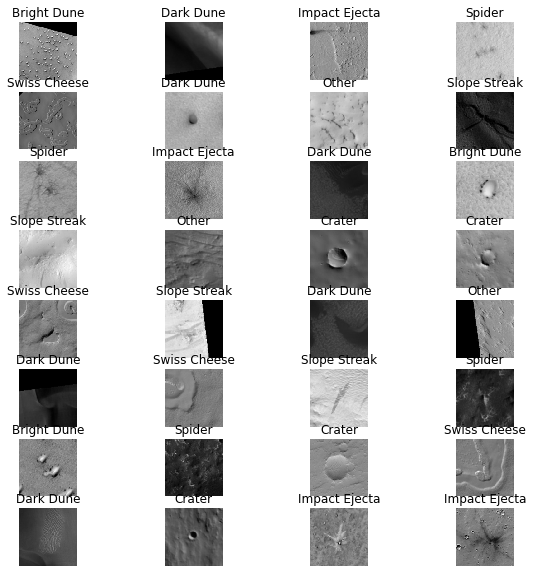

In [19]:
predict = prepare_for_training(test_ds)

prd_img, prd_lbl = next(iter(predict))

show_batch(prd_img.numpy(), prd_lbl.numpy())

In [20]:
model.predict(prd_img.numpy(),steps=1).round()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 